# LSTM with autoencoder outliner detection

https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection/blob/master/Sensor%20Anomaly%20Detection.ipynb

https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb

https://machinelearningmastery.com/lstm-autoencoders/


<img src='https://i1.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_Detection_contextual_anomalies.jpg?ssl=1 ' >



link: https://i1.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_Detection_contextual_anomalies.jpg?ssl=1

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 26.9MB/s]


In [3]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


df_reg=df
import numpy as np
csv=np.genfromtxt('spx.csv',delimiter=',')

#calc the moving average
df['SMA_Temp']=df['close'].rolling(window = 200, min_periods = 1).mean()
df['index'] = range(1, len(df) + 1)

df.head()

#df.set_index("close", inplace = True)
df



<ipython-input-3-29be69e4ba93>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


,close,SMA_Temp,index
date,,,
1986-01-02,209.59,209.590000,1
1986-01-03,210.88,210.235000,2
1986-01-06,210.65,210.373333,3
1986-01-07,213.80,211.230000,4
1986-01-08,207.97,210.578000,5
...,...,...,...
2018-06-25,2717.07,2664.416800,8188
2018-06-26,2723.06,2665.724950,8189
2018-06-27,2699.63,2666.782550,8190


In [4]:
# calc std. deviation and mean
std_x_train=np.std(df["close"])
mean_x_train=np.mean(df["close"])

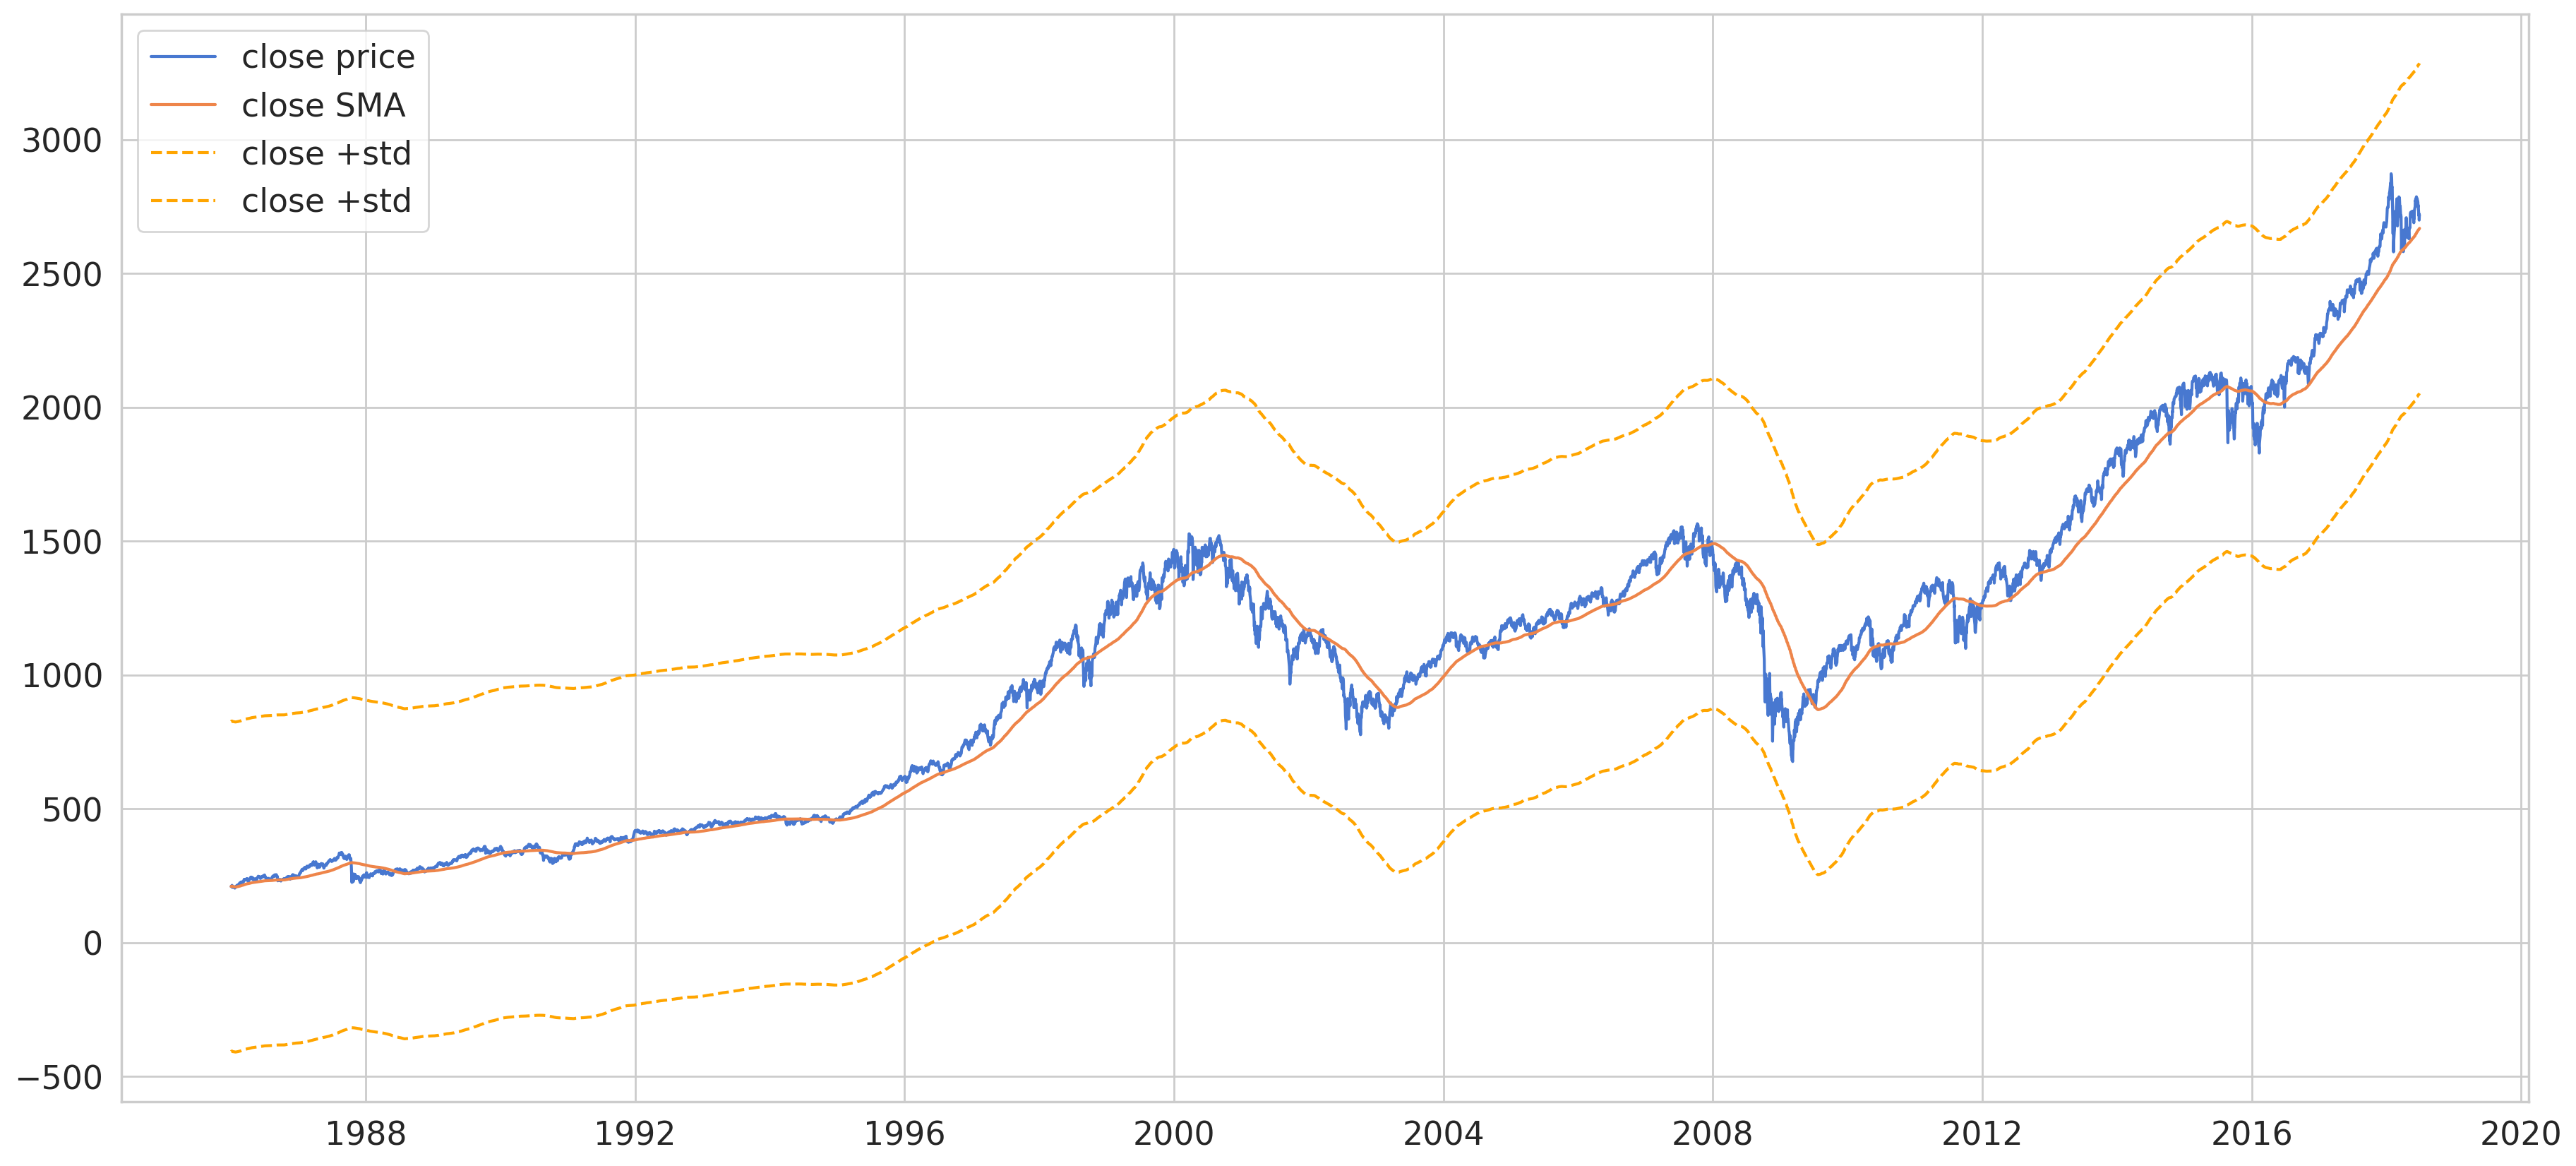

In [5]:
rcParams['figure.figsize'] = 22, 10
import matplotlib.pyplot as plt

plt.plot(df.index,df["close"], label='close price')
plt.plot(df.index,df["SMA_Temp"] ,label='close SMA')

plt.plot(df.index,df["SMA_Temp"]+ std_x_train,label='close +std' , color="orange",linestyle='dashed')
plt.plot(df.index,df["SMA_Temp"]- std_x_train,label='close +std', color="orange",linestyle='dashed')

plt.legend();

In [6]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 3) (1639, 3)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])



train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

<ipython-input-7-7cee758c831f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-7-7cee758c831f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [8]:
# create the dataset for the timeseries and time steps

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

### look 30 days back for prediction

In [9]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)



(6523, 30, 1)


## create the model

### autoencoder and LSTM

In [10]:
X_train.shape[1]
X_train.shape

(6523, 30, 1)

In [11]:
X_train.shape[0]

6523

In [12]:
X_train.shape[1]

30

In [13]:
X_train.shape[2]

1

In [14]:
model = keras.Sequential()

#encoder
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.1))


#decoder
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 64)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             65        
 ributed)                                               

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
184/184 [==============================] - 25s 13ms/step - loss: 0.1858 - val_loss: 0.1857
Epoch 2/20
184/184 [==============================] - 2s 9ms/step - loss: 0.1456 - val_loss: 0.2075
Epoch 3/20
184/184 [==============================] - 2s 9ms/step - loss: 0.1468 - val_loss: 0.1547
Epoch 4/20
184/184 [==============================] - 4s 20ms/step - loss: 0.1486 - val_loss: 0.1515
Epoch 5/20
184/184 [==============================] - 3s 15ms/step - loss: 0.1558 - val_loss: 0.1573
Epoch 6/20
184/184 [==============================] - 2s 11ms/step - loss: 0.1447 - val_loss: 0.1689
Epoch 7/20
184/184 [==============================] - 1s 7ms/step - loss: 0.1327 - val_loss: 0.1539
Epoch 8/20
184/184 [==============================] - 1s 7ms/step - loss: 0.1263 - val_loss: 0.1354
Epoch 9/20
184/184 [==============================] - 1s 7ms/step - loss: 0.1198 - val_loss: 0.1124
Epoch 10/20
184/184 [==============================] - 1s 7ms/step - loss: 0.1166 - val_loss: 0

In [16]:
y_hat=model.predict(X_test)
y_hat.reshape(-1,30)
y_hat.shape

model.evaluate(X_test,y_test)

51/51 [==============================] - 0s 4ms/step - loss: 0.8737


0.8736886382102966

## plot the loss vs. ecpochs

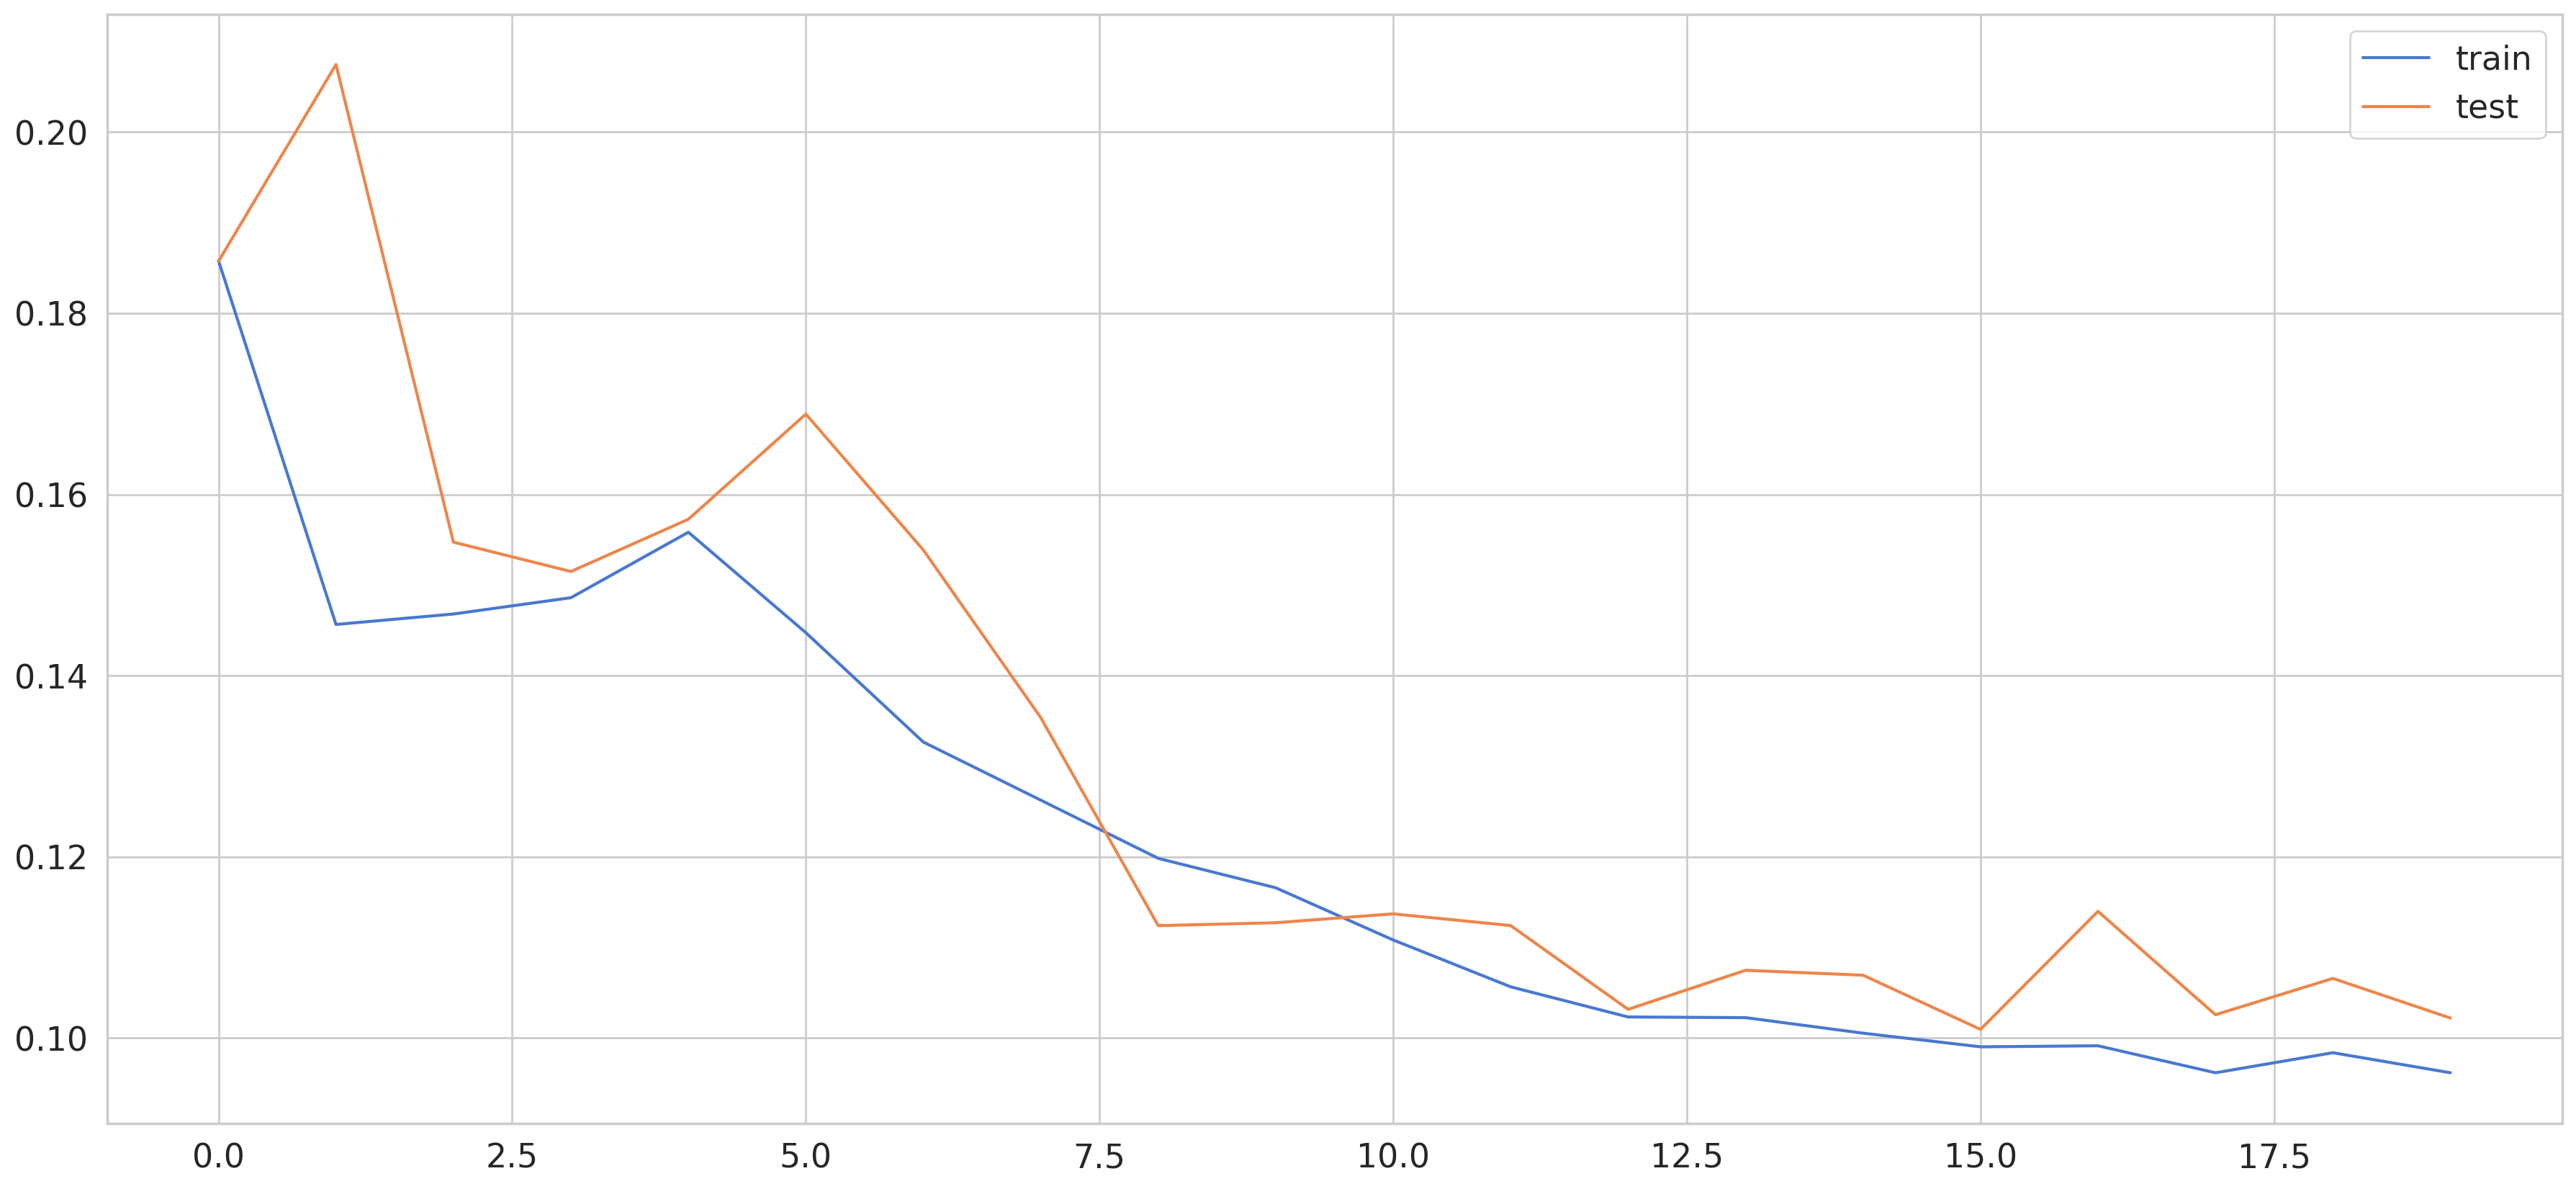

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## calc the loss between ypred - ytest

In [18]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

204/204 [==============================] - 1s 3ms/step


<ipython-input-19-ca47f140882d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=100, kde=True);


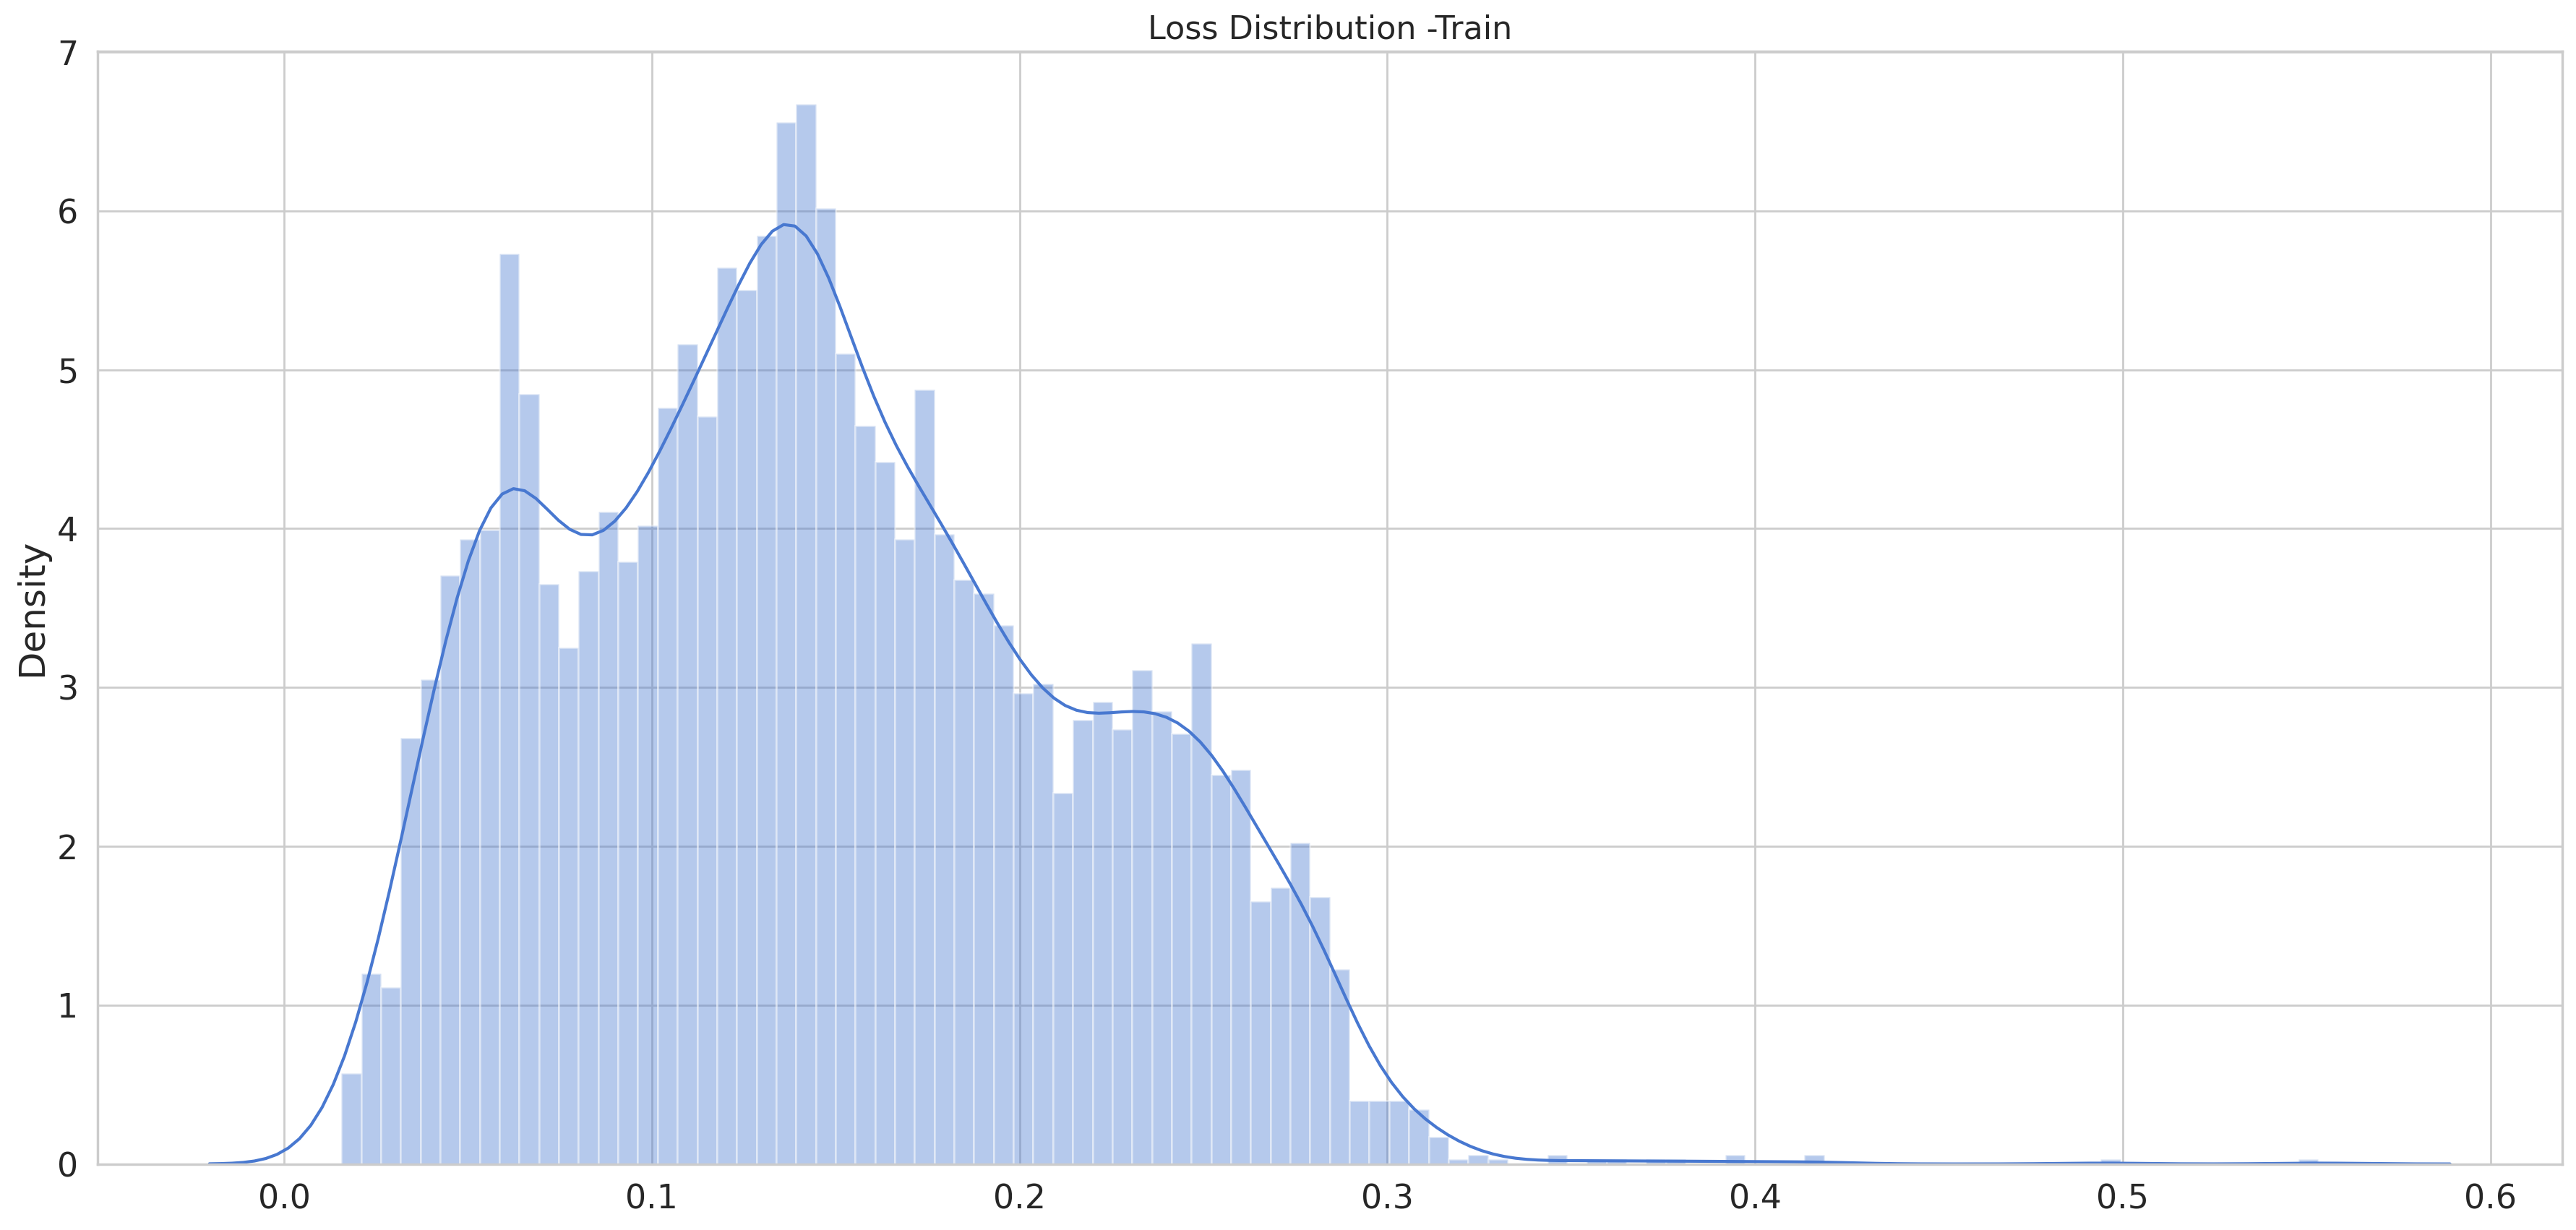

In [19]:
plt.title('Loss Distribution -Train', fontsize=16)
sns.distplot(train_mae_loss, bins=100, kde=True);

In [20]:
X_test_pred = model.predict(X_test)


test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

51/51 [==============================] - 0s 3ms/step


<ipython-input-21-b041013f001a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_mae_loss, bins=50, kde=True);


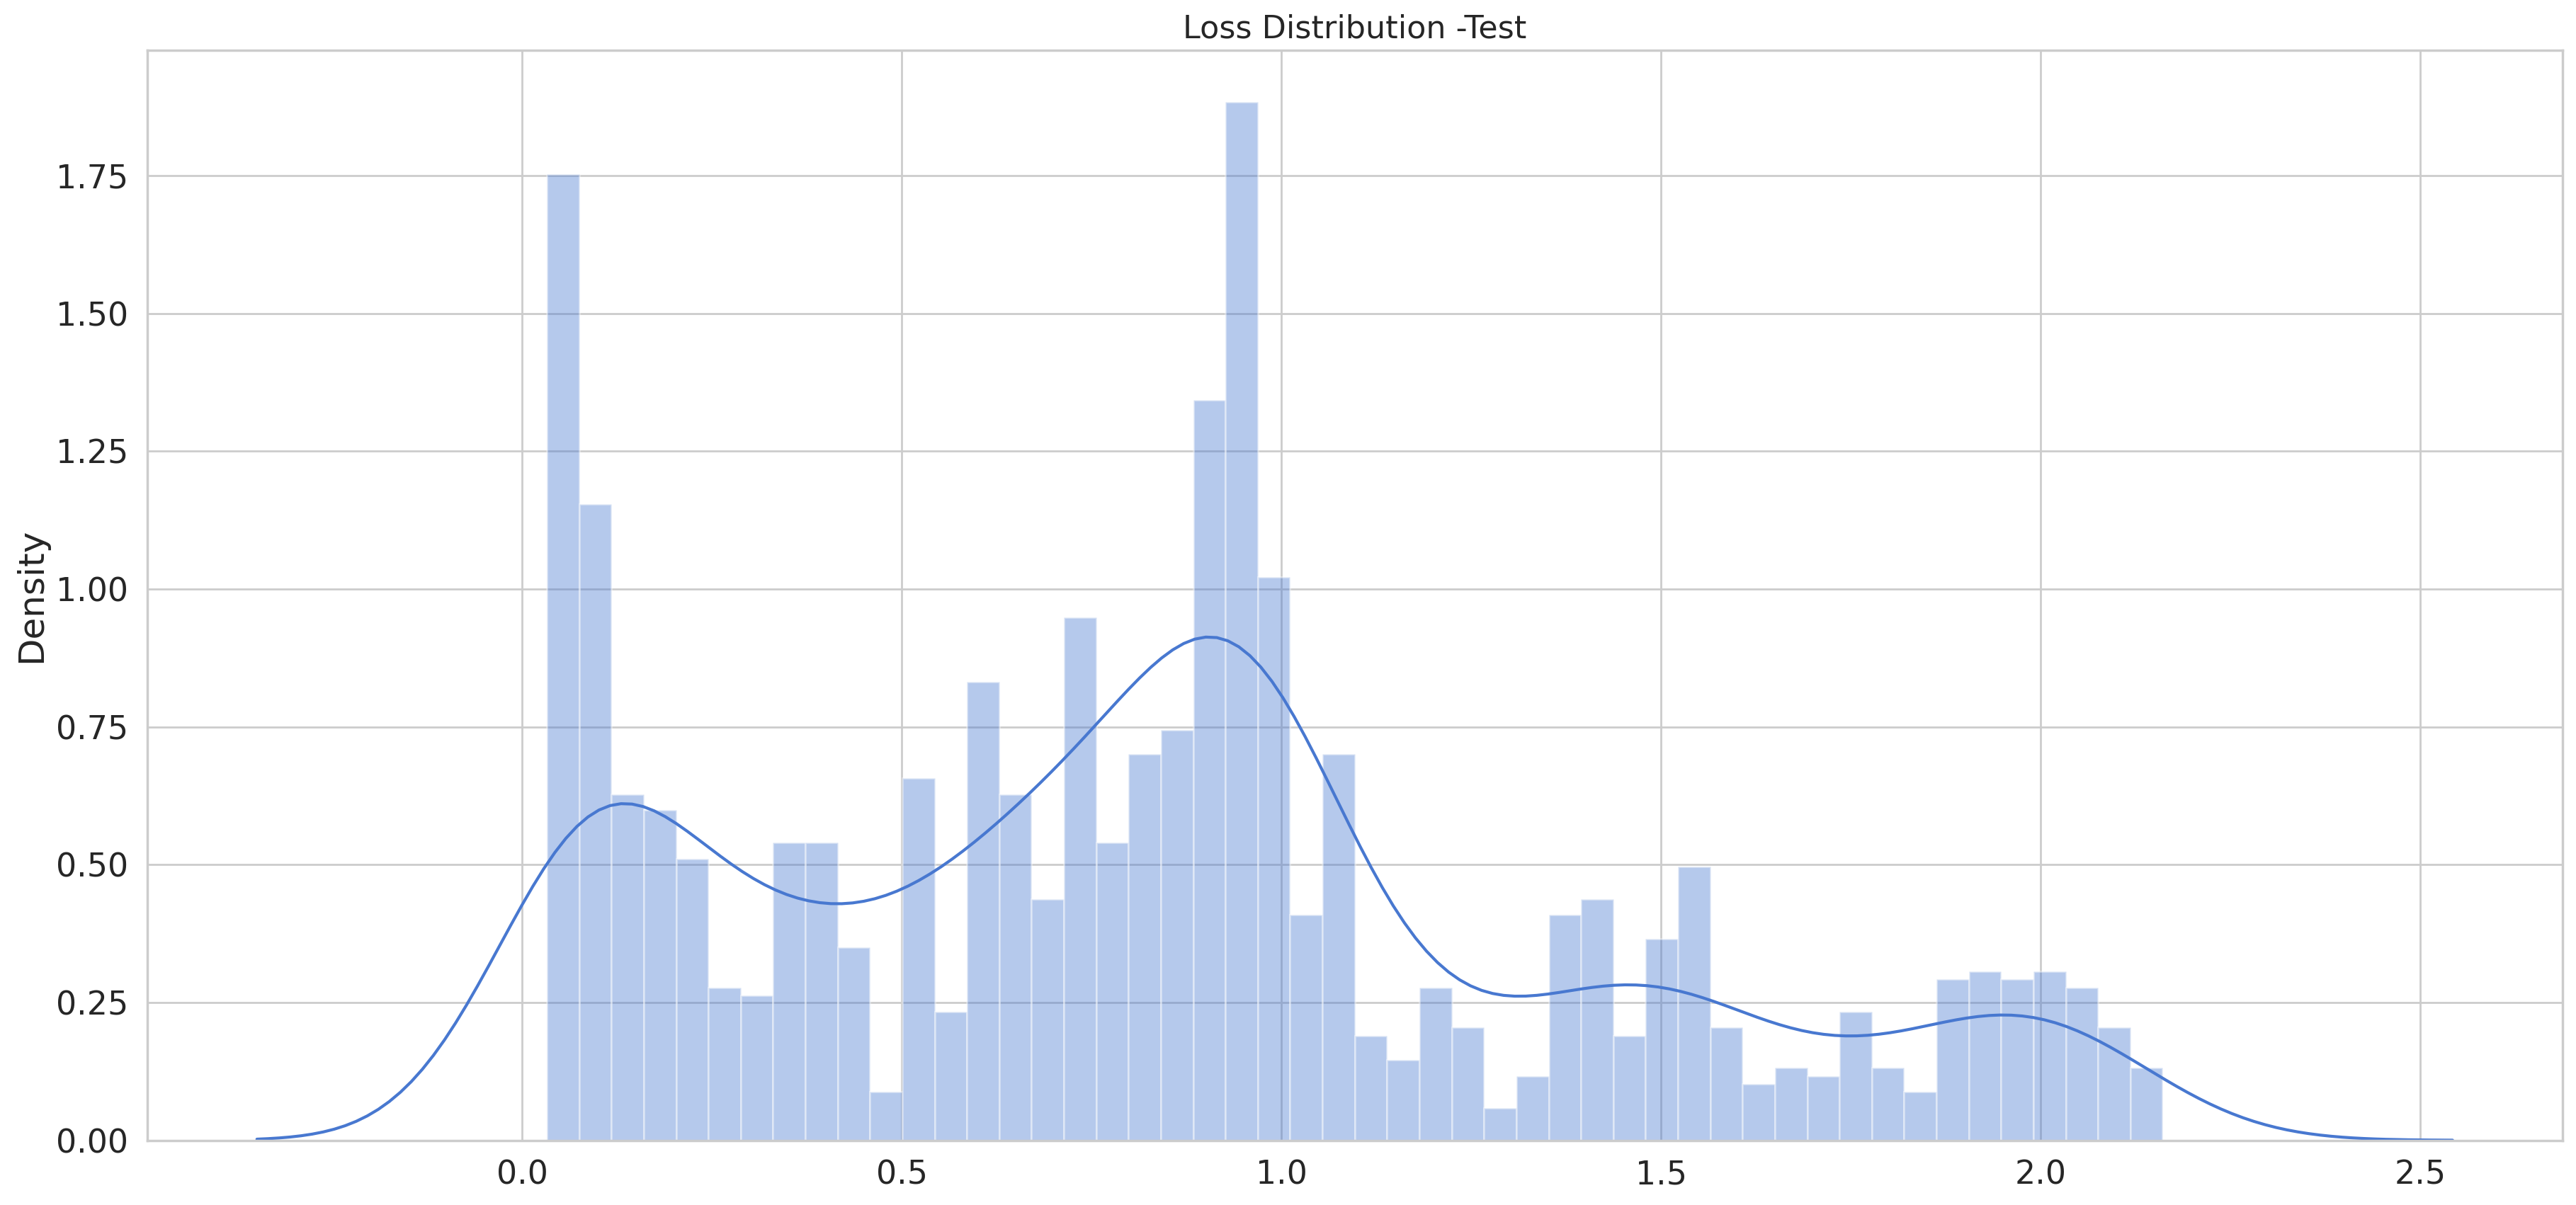

In [21]:
plt.title('Loss Distribution -Test', fontsize=16)
sns.distplot(test_mae_loss, bins=50, kde=True);

## calc threshold with std. deviation

In [22]:




test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss

#calculate threshold by std deviation *3

std_x_train=np.std(test_score_df.loss)*3
mean_x_train=np.mean(test_score_df.loss)

THRESHOLD = std_x_train

test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

THRESHOLD

1.6710621288698007

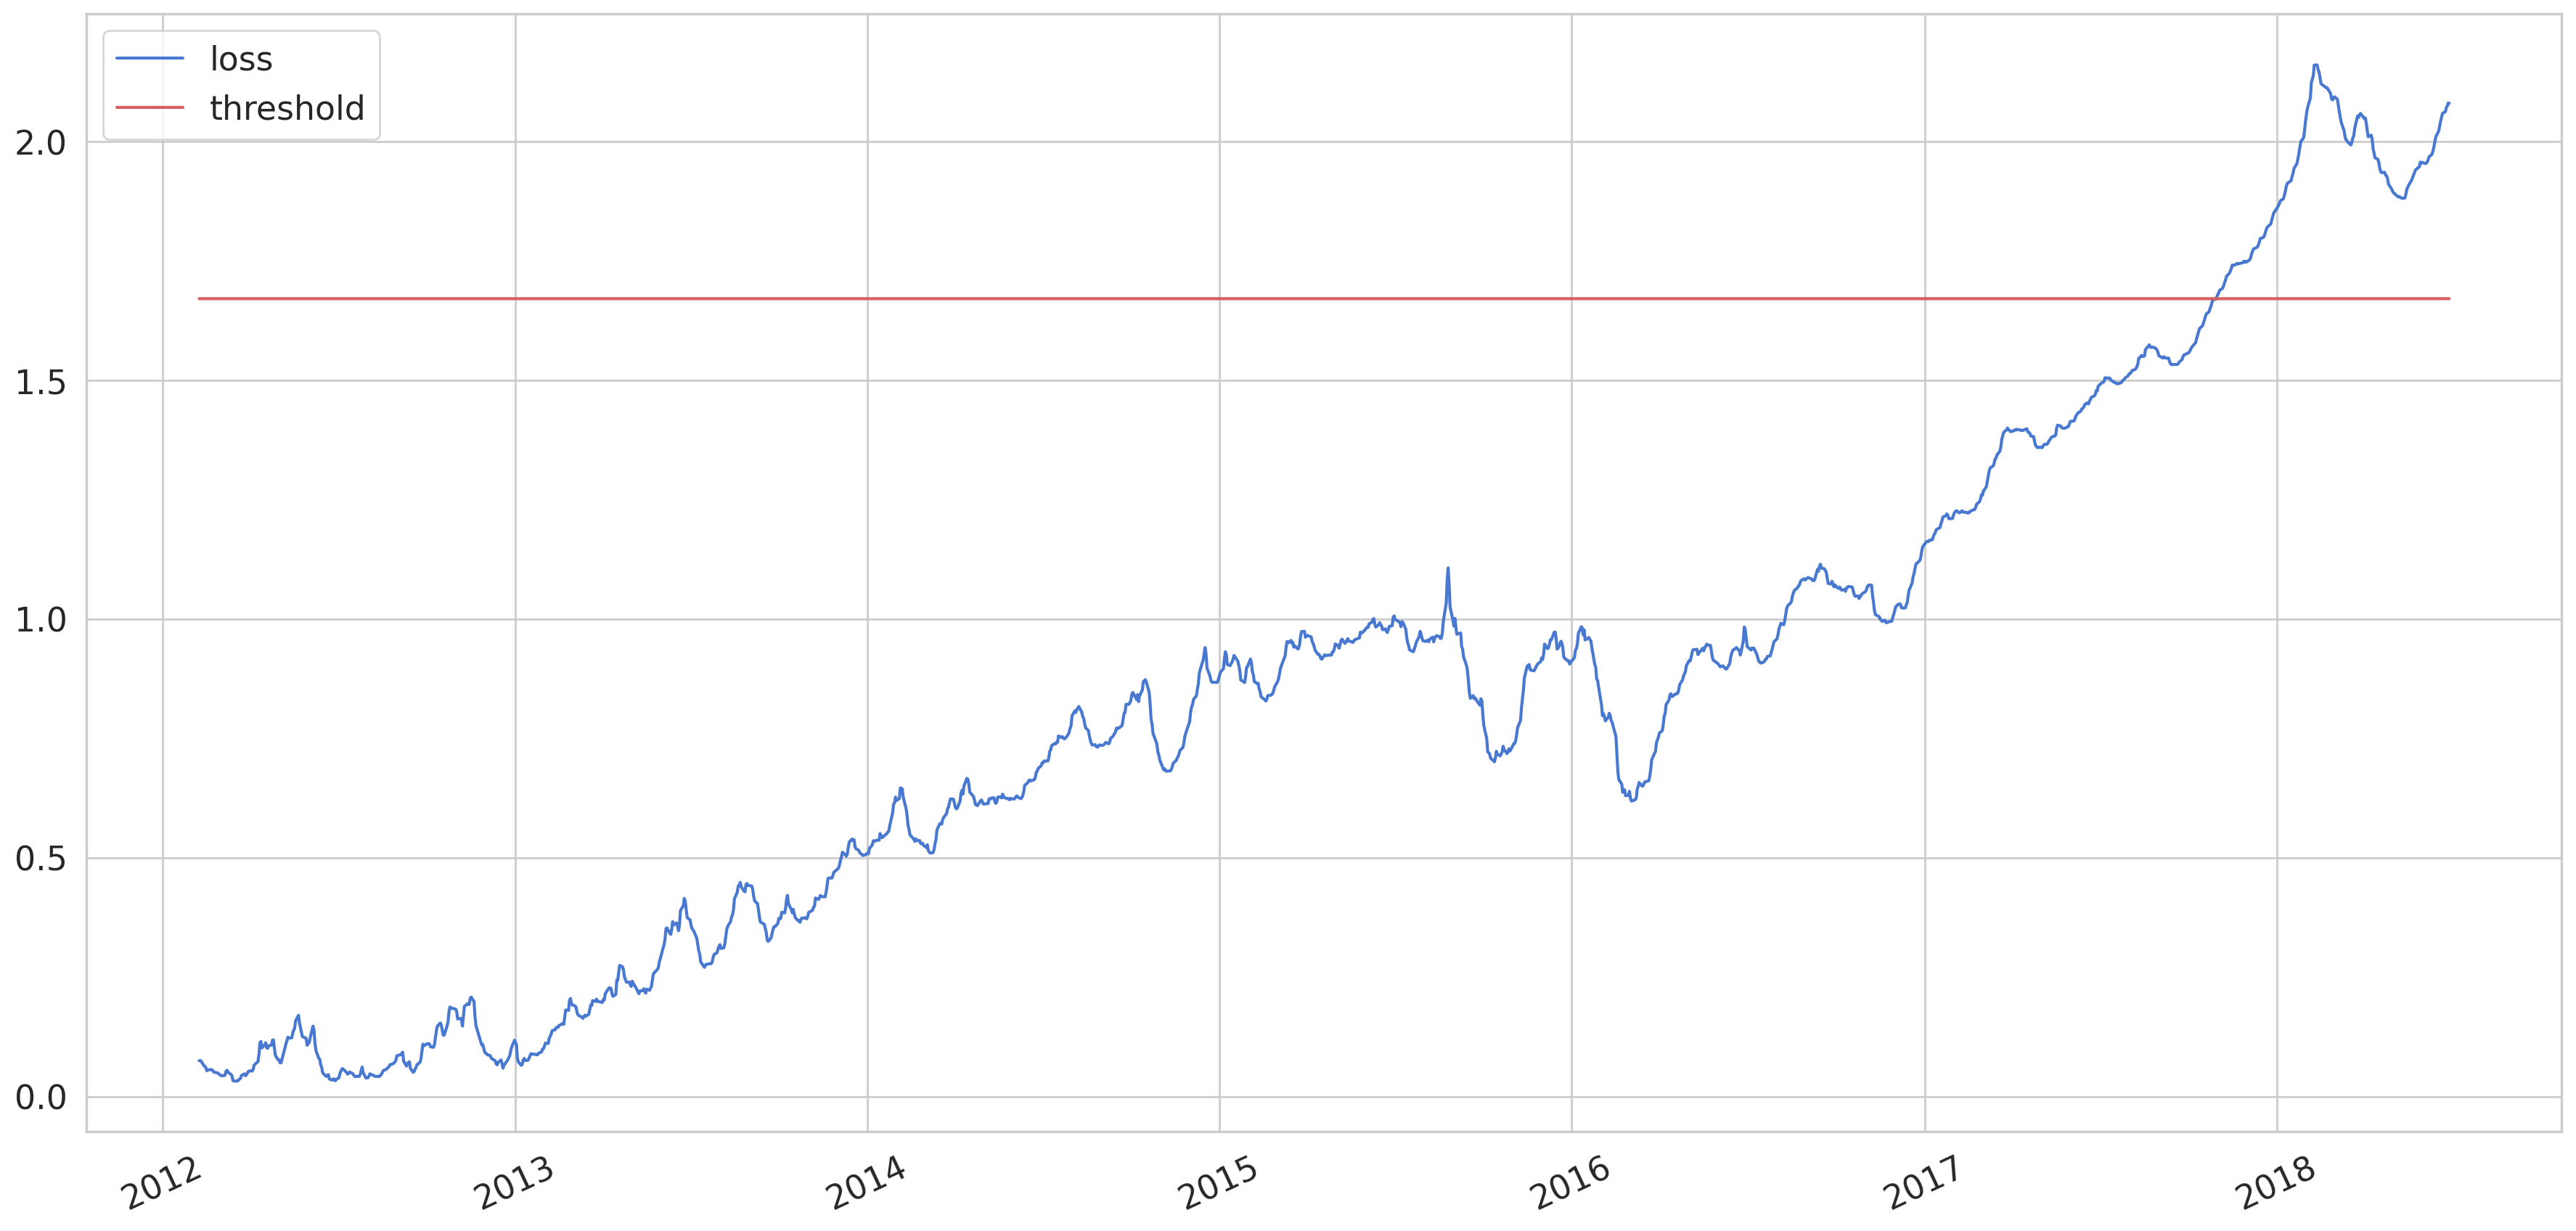

In [23]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold', color="r")
plt.xticks(rotation=25)
plt.legend();

## print and plot the anomalies

In [28]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head(50)

,loss,threshold,anomaly,close
date,,,,
2017-10-31,1.674912,1.671062,True,4.153370
2017-11-01,1.679433,1.671062,True,4.163196
2017-11-02,1.683418,1.671062,True,4.164371
2017-11-03,1.688761,1.671062,True,4.183519
2017-11-06,1.692765,1.671062,True,4.191404
2017-11-07,1.697952,1.671062,True,4.190230
2017-11-08,1.704400,1.671062,True,4.199193
2017-11-09,1.709753,1.671062,True,4.175802
2017-11-10,1.717705,1.671062,True,4.170242


In [29]:
# counting the anomalies

anomalies_str=str(anomalies.count())
anomalies_str

'loss         167\nthreshold    167\nanomaly      167\nclose        167\ndtype: int64'

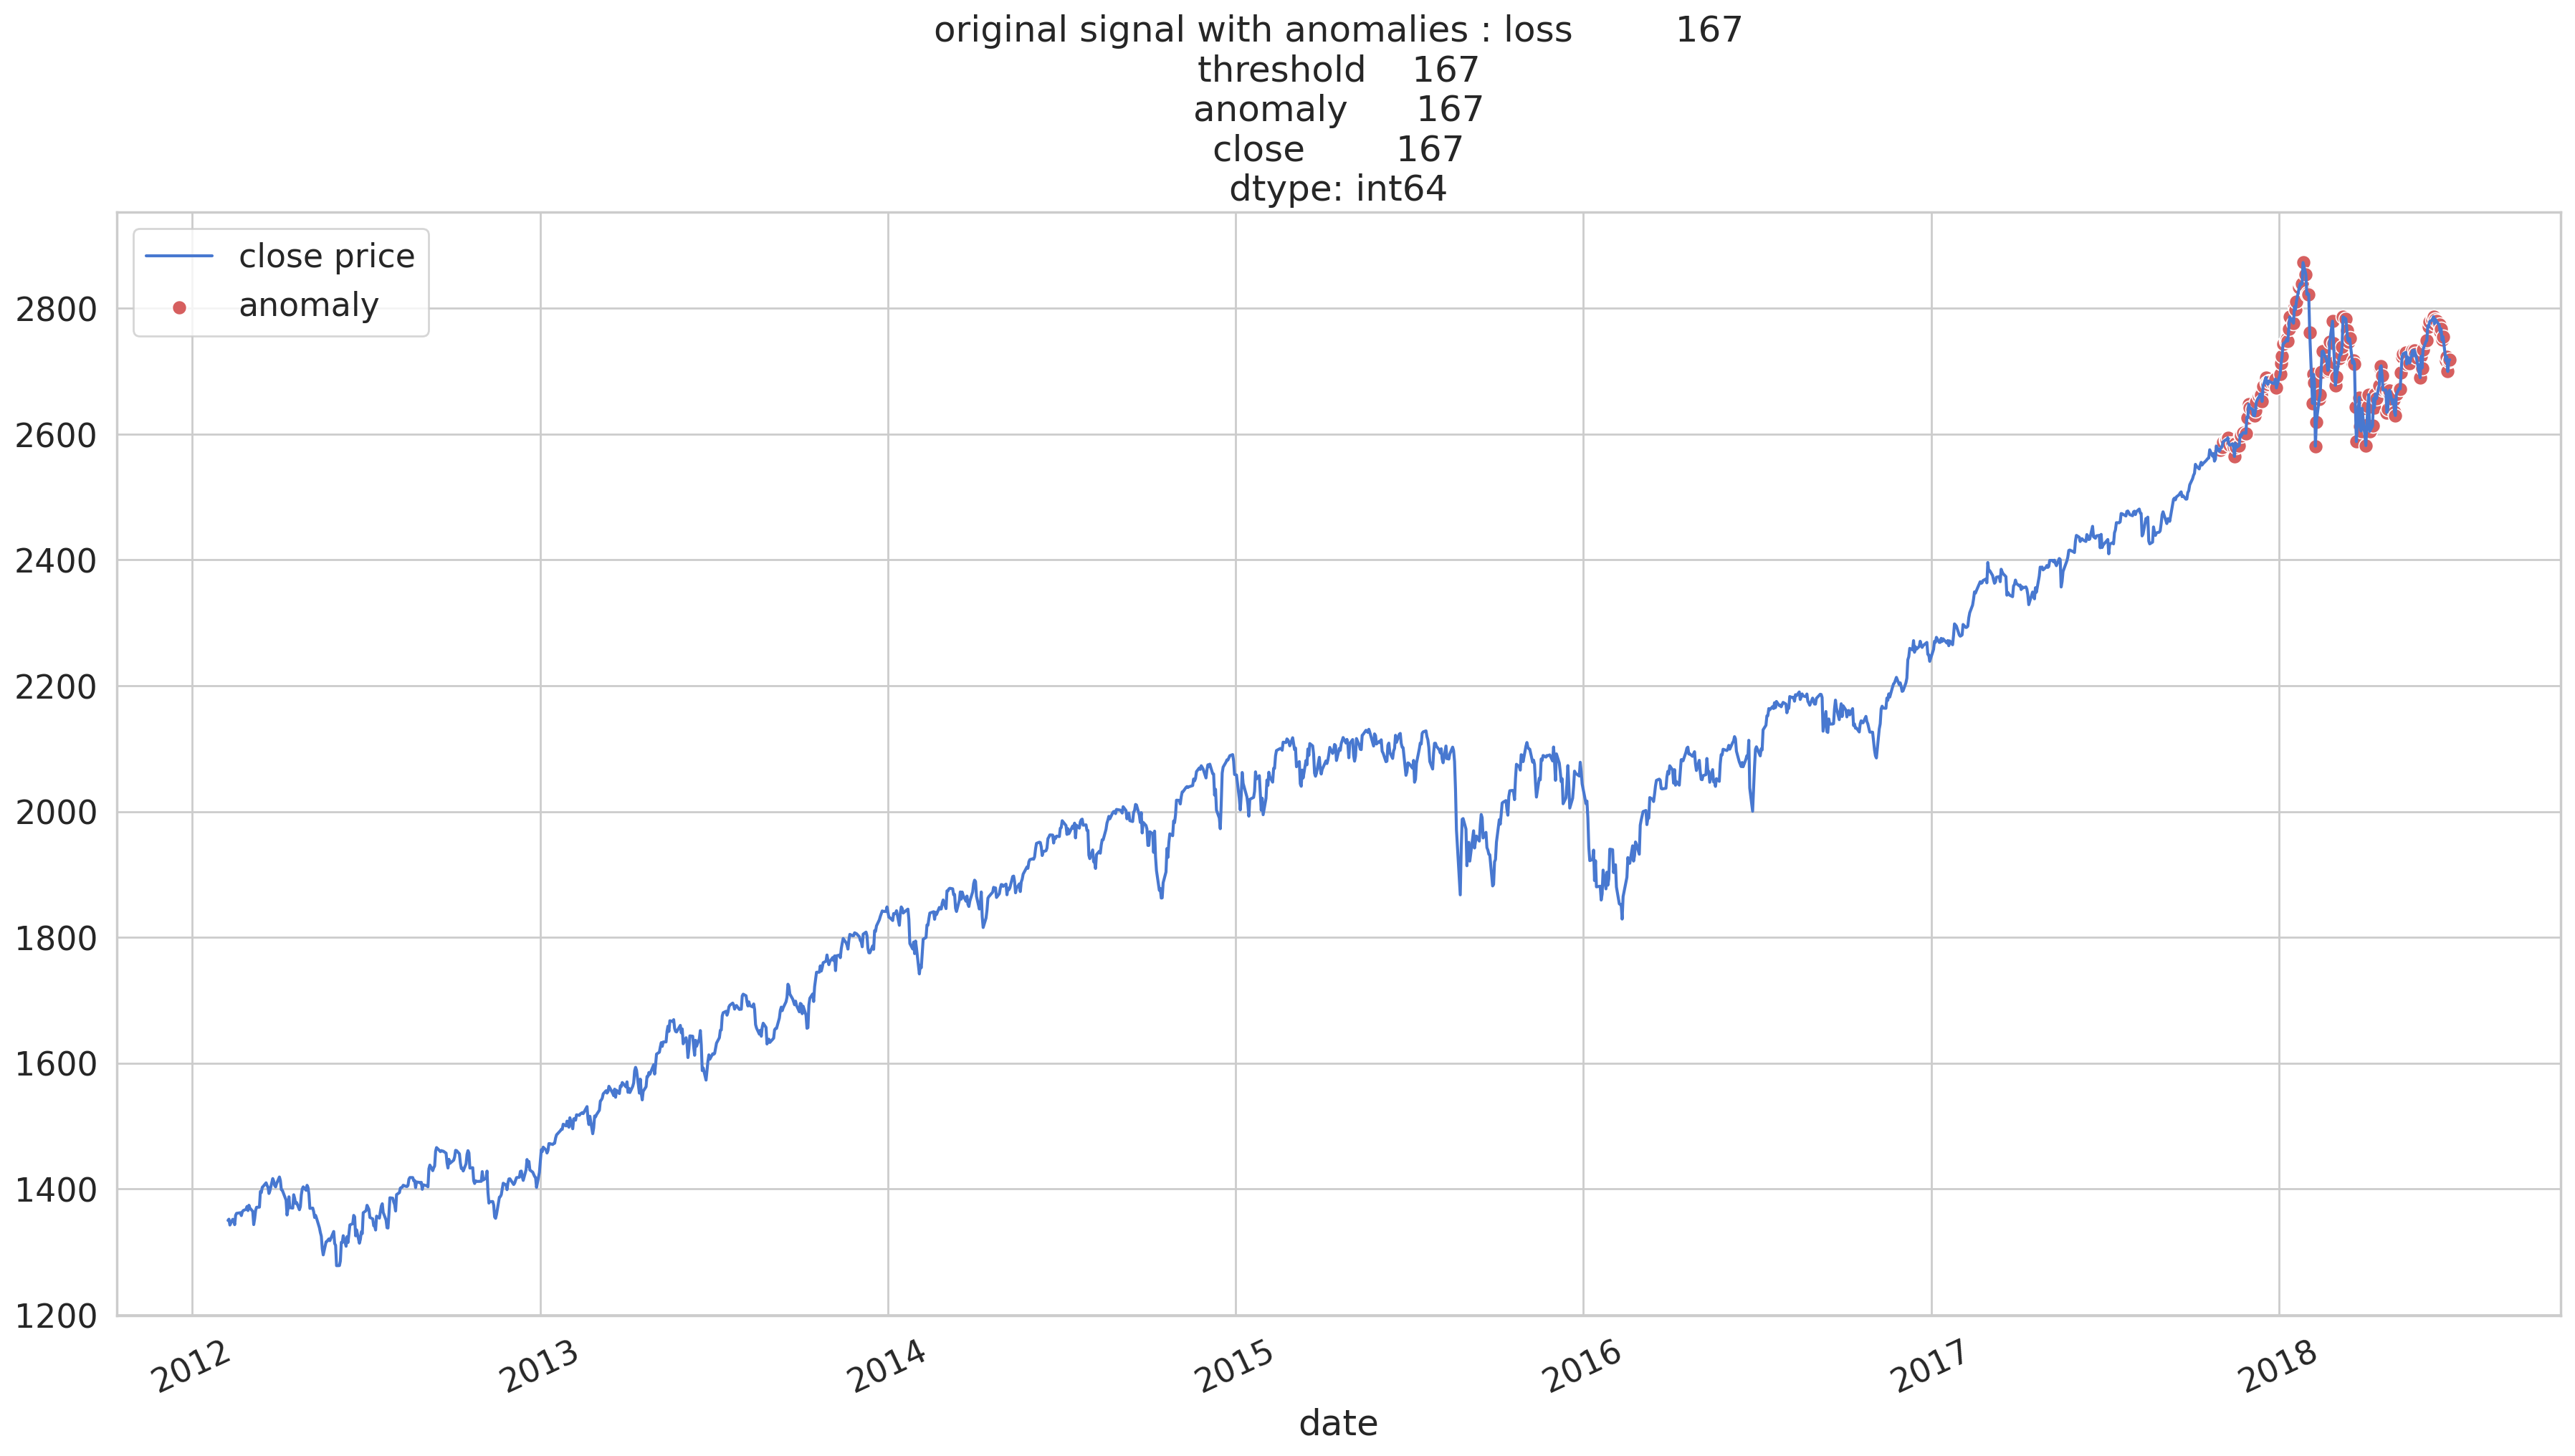

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the test.close data is reshaped to a 2D array
test_close_reshaped = test[TIME_STEPS:].close.values.reshape(-1, 1)
anomalies_close_reshaped = anomalies.close.values.reshape(-1, 1)

# Plot the close price
plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test_close_reshaped),
    label='close price'
);

# Plot the anomalies
sns.scatterplot(
    x=anomalies.index,
    y=scaler.inverse_transform(anomalies_close_reshaped).flatten(),
    color=sns.color_palette()[3],
    s=52,
    label='anomaly'
)

plt.xticks(rotation=25)
plt.title('original signal with anomalies : '+anomalies_str)
plt.legend()
plt.show()
